In [19]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

import matplotlib as mpl
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from sklearn.preprocessing import MinMaxScaler
from pytensor.tensor.math import gammaln, log

from lifelines.utils import concordance_index
from sklearn.metrics import root_mean_squared_error

from xarray import open_dataset # To read the trace of an already trained Bayesian model

import warnings
warnings.filterwarnings('ignore')

In [20]:
ALPHA = 0.05 # Significance level
TRAIN = True # Train the Bayesian model? Training it is taking too much time

CONTINUOUS_VARIABLES = [
    "age",
    "size",
    "nodes",
    "prog",
    "oest"
]

CATEGORICAL_VARIABLES = [
    "treat",
    "men",
    "grade"
]

PREDS = [
    "age",
    "size",
    "nodes",
    "prog",
    "oest",
    "treat_1",
    "men_2",
    "grade_2",
    "grade_3"
]

In [21]:
DatOriginal = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')

## Preprocessing the data

Apply MinMaxScaler into continuous variables

In [22]:
scaler = MinMaxScaler()

DatOriginal[CONTINUOUS_VARIABLES] = scaler.fit_transform(DatOriginal[CONTINUOUS_VARIABLES])

Get dummies for categorical variables

In [23]:
DatOriginal = pd.get_dummies(DatOriginal, columns=CATEGORICAL_VARIABLES, drop_first=True)

## Split the data into training and testing

In [24]:
DatOriginal = DatOriginal.sort_values("status").reset_index(drop=True)

In [25]:
DatTraining = DatOriginal.iloc[:-75] 
DatTesting = DatOriginal.iloc[-75:]

---

Weibull baseline functions

In [26]:
# Baseline Weibull log-hazard function
def WeibullLogHazard(t, alpha, beta):
    return -alpha*np.log(beta) + np.log(alpha) + (alpha-1)*np.log(t)

# Baseline cumulative hazard function
def WeibullCumulativeHazard(t, alpha, beta):
    return (t/beta)**alpha

Unconditional hazard and survivor functions

In [27]:
# Unconditional survivor function
def UnconditionalSurvivor(t, theta, alpha, beta):
    return (1 + 1/theta * WeibullCumulativeHazard(t, alpha, beta))**(-theta)

Quantile survival time

In [28]:
def TimeQuantile(p, theta, alpha, beta):
    return beta * (theta * ((1-p)**(-1/theta)-1))**(1/alpha)

Log-likelihood

In [29]:
def LogLikelihood(t, event, theta, alpha, beta):
    return theta*log(theta) - gammaln(theta) + gammaln(theta+event) + event*WeibullLogHazard(t, alpha, beta) - (theta+event)*log(theta + WeibullCumulativeHazard(t, alpha, beta))

---

## Fit the Weibull AFT with Gamma Frailty model using Bayesian approach

$$
\begin{align*}
T|\alpha,\beta &\sim \text{Weibull}(\alpha,\beta) \\
\alpha|\mu_\alpha &= \exp\{\mu_\alpha\} \\
\mu_\alpha &\sim \textsf{Normal}(0,1) \\
\beta|\mu_\beta,\vec{\zeta} &= \exp\{\mu_\beta+\vec{\zeta}^T\vec{X}\} \\
\mu_\beta &\sim \textsf{Normal}(0,1) \\
\zeta_j &\sim \textsf{Normal}(0,1) \\
\text{Frailty}|\theta &\sim \textsf{Gamma}(\theta, \theta) \\
\theta &\sim \textsf{Exponential}(1)
\end{align*}
$$

In [30]:
XTraining = DatTraining[PREDS]
XTesting = DatTesting[PREDS]

coords = {"preds": PREDS}

y = DatTraining["time"].values
ev = (DatTraining["status"]==1).values

In [31]:
with pm.Model(coords=coords, check_bounds=False) as WeibullFrailtyRegression:
    X_data = pm.Data("X_data_obs", XTraining)

    # Frailty
    Theta = pm.Exponential("Theta", 1)

    # Regression
    MuBeta = pm.Normal("MuBeta", 0, 1)
    Zeta = pm.Normal("Zeta", 0, 1, dims="preds")

    # Weibull parameters
    MuAlpha = pm.Normal("MuAlpha", 0, 1)
    Alpha = pm.Deterministic("Alpha", np.exp(MuAlpha))
    Beta = pm.Deterministic("Beta", np.exp(MuBeta + pm.math.dot(Zeta, X_data.T)))

    # Time quantile
    #MedianTime = pm.Deterministic("MedianTime", TimeQuantile(0.5, Theta, Alpha, Beta))

    # Log-likelihood
    pm.Potential(
        "Loglikelihood", LogLikelihood(y, ev, Theta, Alpha, Beta)
    )

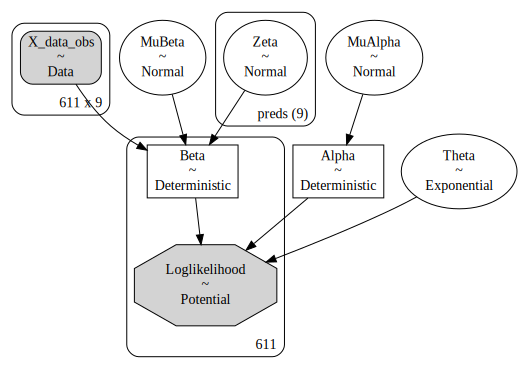

In [32]:
pm.model_to_graphviz(WeibullFrailtyRegression)

---

In [33]:
if TRAIN:
    with WeibullFrailtyRegression:
        TraceWeibullGammaFrailty = pm.sample(draws=500, tune=500, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Theta, MuBeta, Zeta, MuAlpha]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


Save the trace

In [34]:
if TRAIN:
    TraceWeibullGammaFrailty.posterior.to_netcdf("WeibullGammaFrailty.h5", engine="scipy")

Load the trace with different options

In [35]:
if not TRAIN:
    TraceWeibullGammaFrailty = open_dataset("WeibullGammaFrailty.h5", engine="scipy")

In [36]:
Summary = az.summary(TraceWeibullGammaFrailty, kind="stats", stat_focus="median", hdi_prob=1-ALPHA)
Summary[Summary.index.str.startswith(("Theta", "MuAlpha", "Alpha", "MuBeta", "Zeta"))]

,median,mad,eti_2.5%,eti_97.5%
MuBeta,6.809,0.180,6.270,7.340
Zeta[age],1.328,0.282,0.529,2.198
Zeta[size],-0.796,0.253,-1.530,-0.036
Zeta[nodes],-1.977,0.348,-2.948,-1.039
Zeta[prog],2.080,0.434,0.761,3.515
Zeta[oest],0.058,0.227,-0.610,0.694
Zeta[treat_1],0.230,0.074,-0.002,0.453
Zeta[men_2],-0.447,0.114,-0.787,-0.121
Zeta[grade_2],-0.268,0.116,-0.597,0.066
Zeta[grade_3],-0.587,0.128,-0.955,-0.205


In [37]:
HatTheta = Summary["median"]["Theta"]

HatAlpha = Summary["median"]["Alpha"]
HatBetas = Summary[Summary.index.str.startswith("Beta")]["median"]

HatMuBeta = Summary["median"]["MuBeta"]
HatZetas = Summary[Summary.index.str.startswith("Zeta")]["median"]

## Plotting the survivor function 

Calculate the survivor function for the training data set, and plot it to get a visual representation of the model

In [38]:
t_vect = np.linspace(0, 3_000)
Survivors = []

for b in HatBetas:
    for t in t_vect:
        if t==t_vect[0]:
            _ = [UnconditionalSurvivor(t, HatTheta, HatAlpha, b)]
        else:
            _.append(UnconditionalSurvivor(t, HatTheta, HatAlpha, b))
    Survivors.append(_)

Survivors = np.array(Survivors)

SurvivorRiskAdjusted = Survivors.mean(axis=0)

Plot the survival function, and compare it with the KM estimate fit with the training data

In [39]:
KM = KaplanMeierFitter()
KM.fit(DatTraining['time'], DatTraining['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 611 total observations, 387 right-censored observations>

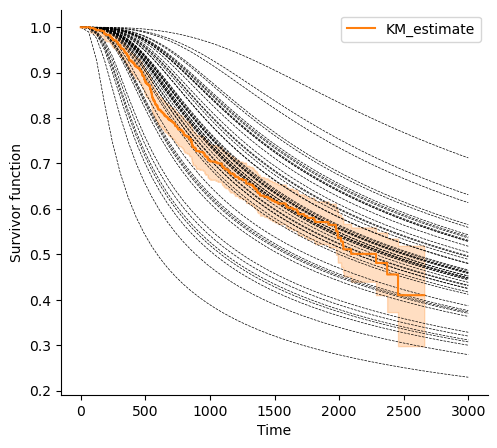

In [40]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

for s in Survivors[:50]:
    ax.plot(
        t_vect,
        s,
        color='k',
        linestyle="--",
        linewidth=0.5
    )

KM.plot_survival_function(color=mpl.colormaps['tab10'].colors[1])

#ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)

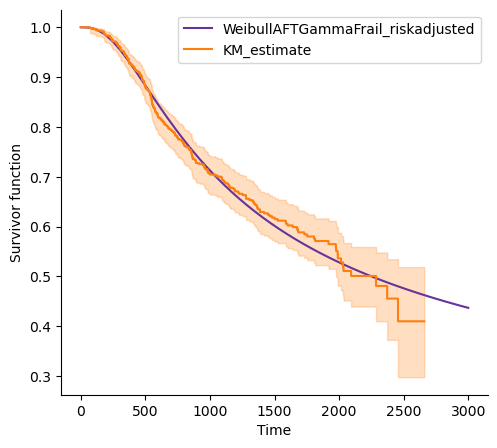

In [41]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

ax.plot(
    t_vect,
    SurvivorRiskAdjusted,
    color='rebeccapurple',
    label="WeibullAFTGammaFrail_riskadjusted"
)

KM.plot_survival_function(color=mpl.colormaps['tab10'].colors[1])

#ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)

Getting the median survival time of the testing observations

In [42]:
HatBetasTesting = np.exp(HatMuBeta + np.dot(DatTesting[PREDS], HatZetas).astype(float))

for b in HatBetas:
    MedianTimeTesting = TimeQuantile(0.5, HatTheta, HatAlpha, HatBetasTesting)

Add the median time as the predicted time for the testing data, and calculate the RMSE.

In [49]:
DatTesting["PredictedTime"] = MedianTimeTesting

Rmse = round(root_mean_squared_error(DatTesting["time"], DatTesting["PredictedTime"]), 4)
CIndex = round(concordance_index(DatTesting["time"], DatTesting["PredictedTime"]), 4)

Rmse, CIndex

(1374.1325, np.float64(0.628))

In [53]:
print("Here is the result from WeibullAFT with Gamma Frailty Model using Bayesian approach")
print(f"RMSE: {Rmse:.2f}")
print(f"Concordance Index: {CIndex:.3f}")

Here is the result from WeibullAFT with Gamma Frailty Model using Bayesian approach
RMSE: 1374.13
Concordance Index: 0.628
